# Analyse BlueSeis BSPF Event Analysis - Backazimuth

In [1]:
import os,sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from functions.compute_backazimuth import __compute_backazimuth

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [4]:
sys.path.append(root_path+"andbro_python/")

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

## Configurations

In [5]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

##
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/ACC/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/baz/"


## Load Data

In [6]:
!ls /home/andbro/kilauea-data/BSPF/data/

adr				 BSPF_baz_estimates.pkl
baz_test			 catalogs
BSPF_2022_E			 event_selection_good.pkl
BSPF_2022_N			 event_selection_reject.pkl
BSPF_2022_Z			 hazfaults2014
BSPF_2023_E			 iadr_baz_estimates.pkl
BSPF_2023_N			 PFO_2022_E
BSPF_2023_Z			 PFO_2022_N
bspf_analysisdata_adr_disp.pkl	 PFO_2022_Z
bspf_analysisdata_adr.pkl	 PFO_2023_Z
bspf_analysisdata_amax_disp.pkl  PFOIX_2023_E
bspf_analysisdata_amax.pkl	 PFOIX_2023_N
bspf_analysisdata_snr_disp.pkl	 PFOIX_2023_Z
bspf_analysisdata_snr.pkl	 trigger3
bspf_baz_estimates_bspf.pkl	 triggered_2022-10-01_2023-06-15.pkl
bspf_baz_estimates_iadr.pkl	 waveforms
bspf_baz_estimates.pkl


In [7]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

In [8]:
num = 5

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

In [9]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

st.detrend("linear");

st.filter("bandpass", freqmin=8.0, freqmax=15, corners=4, zerophase=True);

In [10]:
cut_offs = [
    (70,60), (65,80), (60,100), (60,100), (60,70),
    (60,90), (60,90), (60,90), (62,105), (65,90),
    (62,110), (65,85), (60,105), (63,105), (66,90),
    (60,90), (65,90), (70,95),
]

# st.trim(st[0].stats.starttime+cut_offs[num][0]-10, st[0].stats.endtime-cut_offs[num][1]+10);
st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

In [11]:
# st.plot(equal_scale=False);

## BAZ Estimation

In [12]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

config['eventtime'] = event_time

config['tbeg'], config['tend'] = st[0].stats.starttime, st[0].stats.endtime

## specify window length for baz estimation in seconds
config['win_length_sec'] = 0.3

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 20

## specify steps for degrees of baz
config['step'] = 1



 -> event used for theoretical backazimuth:
 ->  earthquake name :  5km NW of Palomar Observatory, CA

 -> Epicentral distance [m]:       48993.5
 -> Theoretical azimuth [deg]:     58.7
 -> Theoretical backazimuth [deg]: 239.0

 -> using love waves for estimation ...


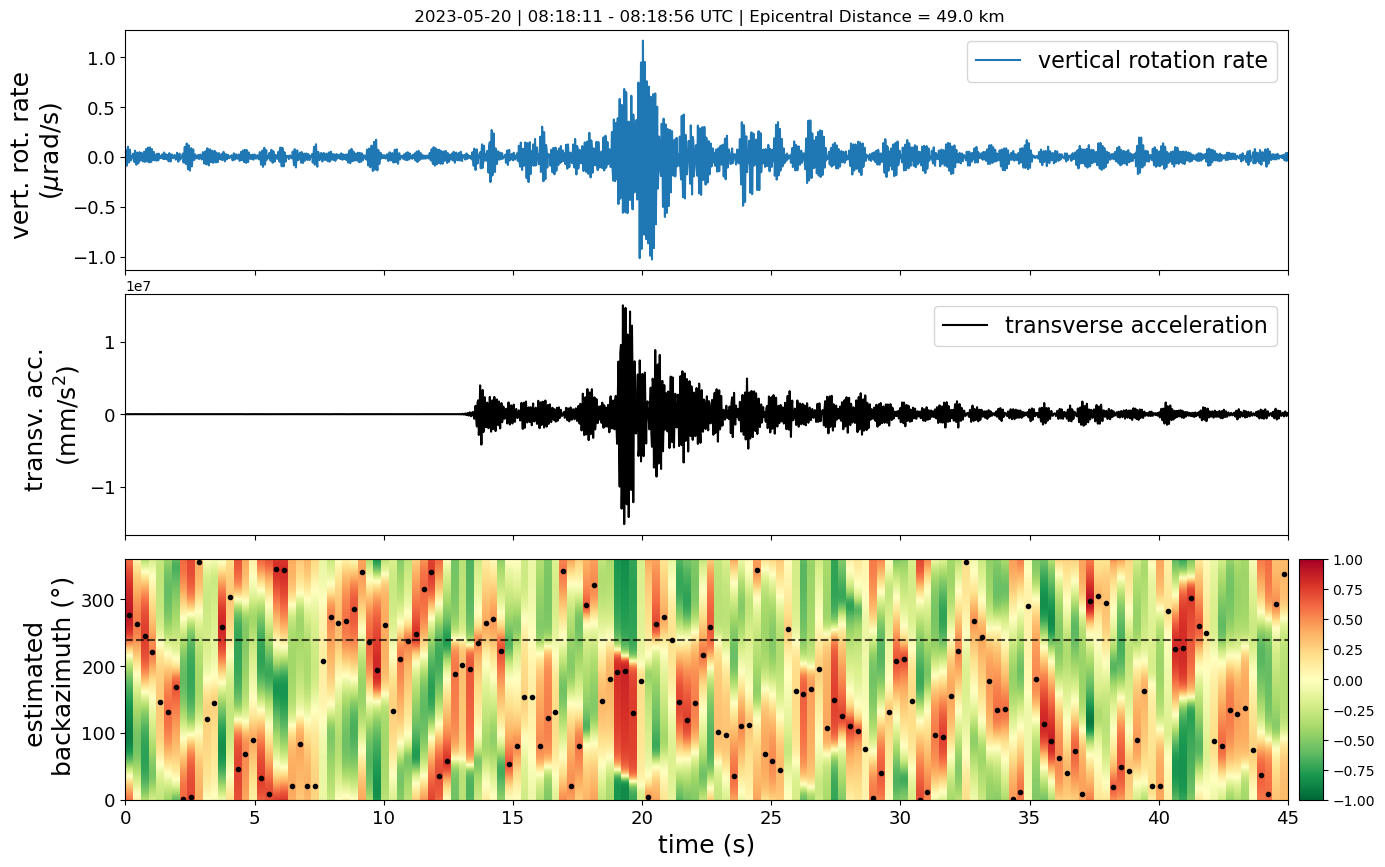

 -> event used for theoretical backazimuth:
 ->  earthquake name :  5km NW of Palomar Observatory, CA

 -> Epicentral distance [m]:       48993.5
 -> Theoretical azimuth [deg]:     58.7
 -> Theoretical backazimuth [deg]: 239.0

 -> using rayleigh waves for estimation ...


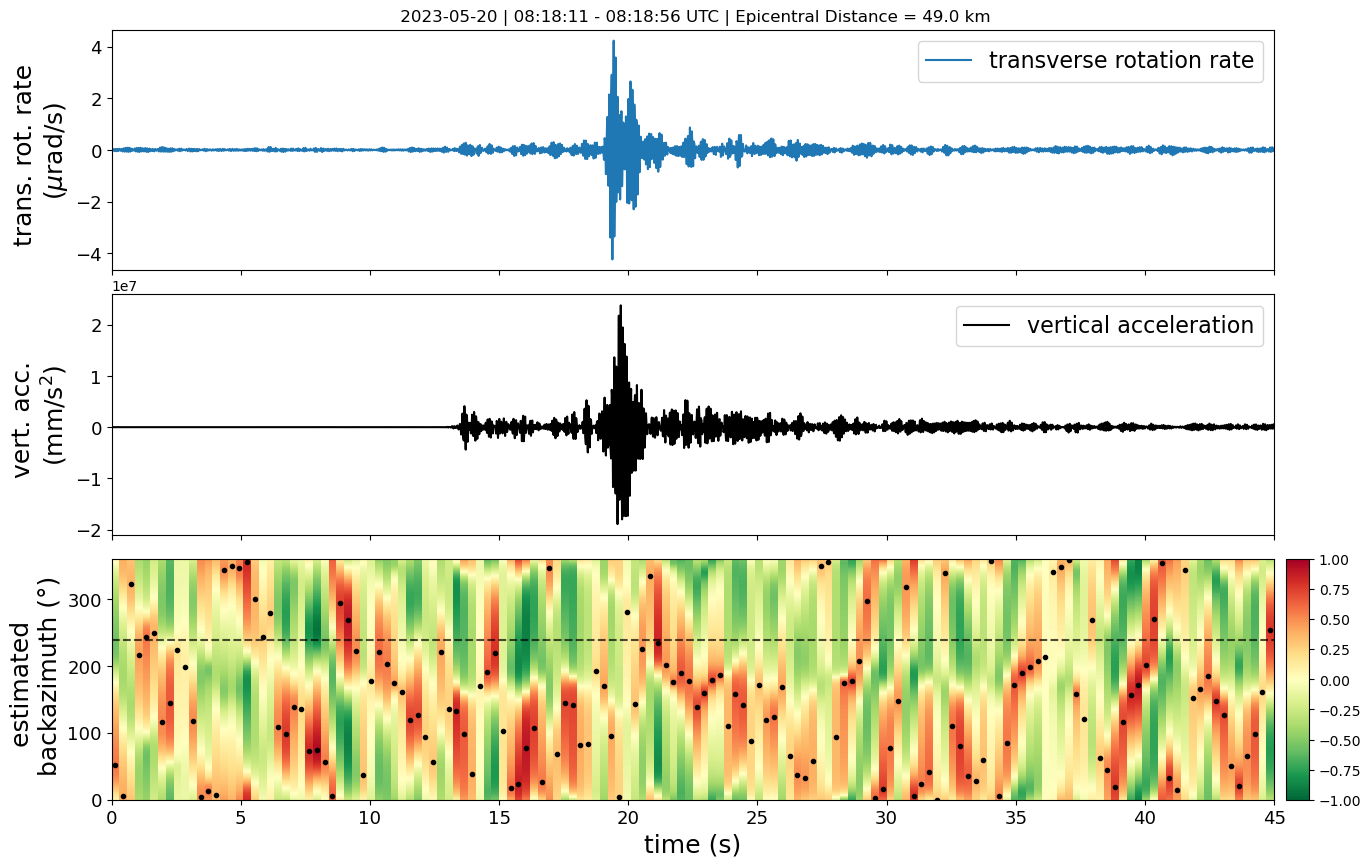

In [29]:
rot = st.select(station="BSPF")
# rot = st.select(station="RPFO", location="in")
acc = st.select(station="PFO*")

# acc.select(channel="*Z")[0].data *= -1
acc.select(channel="*N")[0].data *= -1
acc.select(channel="*E")[0].data *= -1


config['type'] = "love" ## "love" | "rayleigh"
out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

config['type'] = "rayleigh"
out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

## New Approach

In [17]:
# rot = st.select(station="BSPF")
rot = st.select(station="RPFO", location="in")
acc = st.select(station="PFO*")

In [18]:
def __baz_tangent(rot0, acc0, win_time_s=0.5, overlap=0.5, baz_theo=None, cc_thres=None, plot=False):

    from numpy import zeros, nan, ones, nanmean, array, nanmax
    from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy.linalg import eigh
    from obspy.signal.cross_correlation import correlate

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## extract components
    rot_n = rot.select(channel="*N")[0].data
    rot_e = rot.select(channel="*E")[0].data
    acc_z = rot.select(channel="*Z")[0].data

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n,n+n_win))
        n+=n_win


    ## add overlap
    if overlap != 0:
        windows_overlap = []
        for i, w in enumerate(windows):
            if i == 0:
                windows_overlap.append((w[0],w[1]+nover))
            elif i >= int(len(windows)-nover):
                windows_overlap.append((w[0]-nover, w[1]))
            else:
                windows_overlap.append((w[0]-nover, w[1]+nover))
    else:
        windows_overlap = windows

    ## compute baz and ccorr for each window
    baz, ccor = ones(len(windows_overlap))*nan, ones(len(windows_overlap))*nan

    for j, (w1, w2) in enumerate(windows_overlap):

        if int(w2-w1) < 10:
            print(f" -> not enough samples in window (<10)")

        dat = (zeros((len(rot_n[w1:w2]), 2)))
        dat[:,0] = rot_e[w1:w2]
        dat[:,1] = rot_n[w1:w2]

        covar = cov(dat, rowvar=False)

        Cprime, Q = eigh(covar, UPLO='U')

        loc = argsort(abs(Cprime))[::-1]

        Q = Q[:,loc]

        baz0 = -arctan((Q[1,0]/Q[0,0]))*180/pi

        if baz0 <= 0:
            baz0 += 180
        ## __________________________
        ## remove 180° ambiguity

        rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)

#         corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
        corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]


        if (corr_baz > 0):
            baz0 += 180

        ## add new values to array
        if corr_baz > cc_thres:
            baz[j] = baz0
            ccor[j] = corr_baz

    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2

    if plot:

        rot0, acc0 = rot_n, acc_z

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot0)))/df, rot0/max(abs(rot0)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc0)))/df, acc0/max(abs(acc0)), alpha=0.5, color="tab:red", label="acceleration (m/s)")


        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot0)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=4, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel("Backazimuth (°)", fontsize=14)
        ax2.set_ylim(0, 360)
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if baz_theo:
            ax2.axhline(baz_theo, ls=":",c="k")

        plt.show();

        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "fig":fig}
    else:
        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo}

    return out

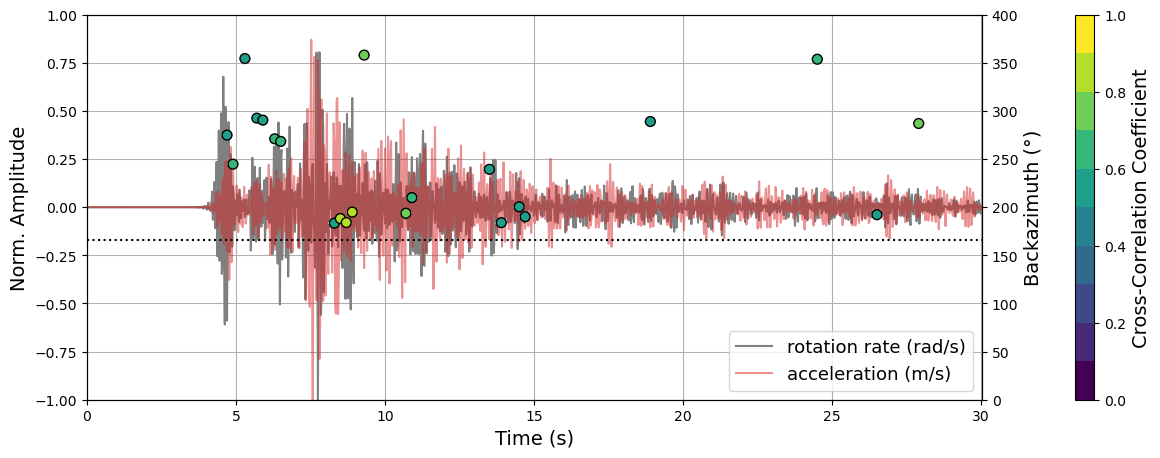

In [19]:
out = __baz_tangent(rot, acc, win_time_s=0.2, overlap=0.5, baz_theo=trig.backazimuth.iloc[0], cc_thres=0.5, plot=True)

## AS LOOP

In [20]:

config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']
config['eventtime'] = event_time

## specify window length for baz estimation in seconds
config['win_length_sec'] = 0.3

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

config['fmin'], config['fmax'] = 10, 15

config['cc_thres'] = 0.4

config['rot_name'] = "bspf"  ## "iadr"; "bspf"

for i in range(0, 17):

    event_time = event_times.origin_time.loc[i]

    try:
        event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
        trig = triggered[triggered.origin == event_time]
    except:
        print(f" -> {i} no event in catalog")


    ## prepare string
    event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

    st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");
    st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

    st = st.detrend("simple");
    st = st.taper(0.01);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

    st = st.trim(st[0].stats.starttime+cut_offs[i][0]-10, st[0].stats.endtime-cut_offs[i][1]+10);

    acc = st.select(station="PFO*").copy();

    if config['rot_name'] == "bspf":
        rot = st.select(station="BSPF").copy();
    elif config['rot_name'] == "iadr":
        rot = st.select(station="RPFO", location="in").copy(); #rot.select(channel="*Z")[0].data *= -1

    config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime

    ## RAYLEIGH
    config['type'] = "rayleigh"
    # out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)

    ## LOVE
    config['type'] = "love"
    # out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)


    ## TAGENT
    out = __baz_tangent(rot, acc, win_time_s=config['win_length_sec'], overlap=config['overlap']/100,
                        cc_thres=config['cc_thres'], baz_theo=trig.backazimuth.iloc[0], plot=False)
    # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_tangent", mode="png", dpi=200)

    _baz = {}
    _baz['event_time'] = event_time
    _baz['event_num'] = num
    _baz['baz_mean'] = np.nanmean(out["baz_est"])
    _baz['baz_median'] = np.nanmedian(out["baz_est"])
    _baz['cc_thres'] = config['cc_thres']
    _baz['baz_theo'] = out["baz_theo"]
    _baz['baz_std'] = np.nanstd(out['baz_est'])
    _baz['percentile_05'] = np.nanpercentile(out['baz_est'], [5])
    _baz['percentile_90'] = np.nanpercentile(out['baz_est'], [90])
    _baz['samples'] = len(out['ccoef']) - np.isnan(out['ccoef']).sum()
    _baz['edist_km'] = trig.distances_km.iloc[0]

    if i == 0:
        df_baz = pd.DataFrame([_baz])
    else:
        df_baz.loc[len(df_baz)] = _baz

df_baz.to_pickle(config['path_to_data']+f"bspf_baz_estimates_{config['rot_name']}.pkl")
print(f" -> writing: {config['path_to_data']}BSPF_baz_estimates_{config['rot_name']}.pkl")

 -> writing: /home/andbro/kilauea-data/BSPF/data/BSPF_baz_estimates_bspf.pkl


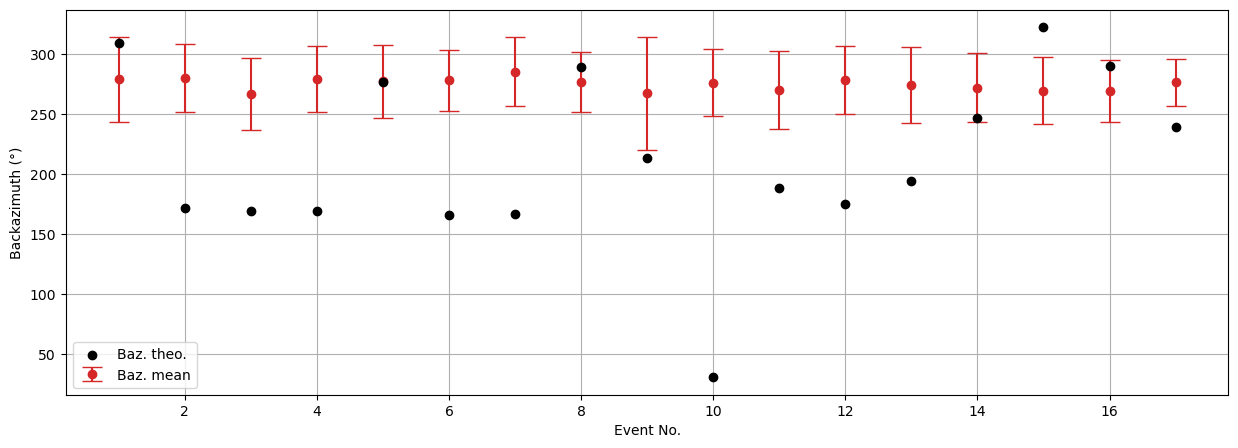

In [21]:
data_baz = df_baz

x = np.arange(1,len(data_baz.event_time)+1)

plt.figure(figsize=(15,5))
plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")
# plt.scatter(np.arange(1,len(data_baz.event_time)+1), data_baz.baz_mean)
plt.errorbar(x, data_baz.baz_mean, yerr=data_baz.baz_std, capsize=7, fmt="o", c="tab:red", zorder=2, label="Baz. mean")
plt.xlabel("Event No.")
plt.ylabel("Backazimuth (°)")
plt.legend(loc=3)
plt.grid(zorder=-1)
plt.show();

In [22]:
def __polar_plot(data1):

    r1 = data1.edist_km

    theta1 = np.radians(data1.baz_mean)
    theta2 = np.radians(data1.baz_theo)

    err = data1.baz_std

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    m1 = ax.scatter(theta1, r1, s=40, c="tab:red", marker="o", lw=0.5, edgecolors="k", zorder=3)
    m1.set_facecolor('none')

    ax.scatter(theta2, r1, s=40, c="darkgrey", lw=0.5, edgecolors="k", zorder=2)

    for i in range(len(r1)):
        ax.plot([theta1[i], theta2[i]], [r1[i], r1[i]], c="k", zorder=1, alpha=0.5, ls=":")

    # ax.bar(theta1, r1, width=err/200, bottom=0.0, color="b", alpha=0.5)
    ax.errorbar(theta1, r1, xerr=err/100, yerr=None, capsize=7, fmt="o", c="tab:red")

    ## station
    ax.scatter(0, 0, zorder=3, s=100, marker='^', c="r", lw=0.8, edgecolors="k")

#     ax.set_rmax(2)

#     ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True, zorder=0)

    ax.set_title("", va='bottom')
    plt.show()

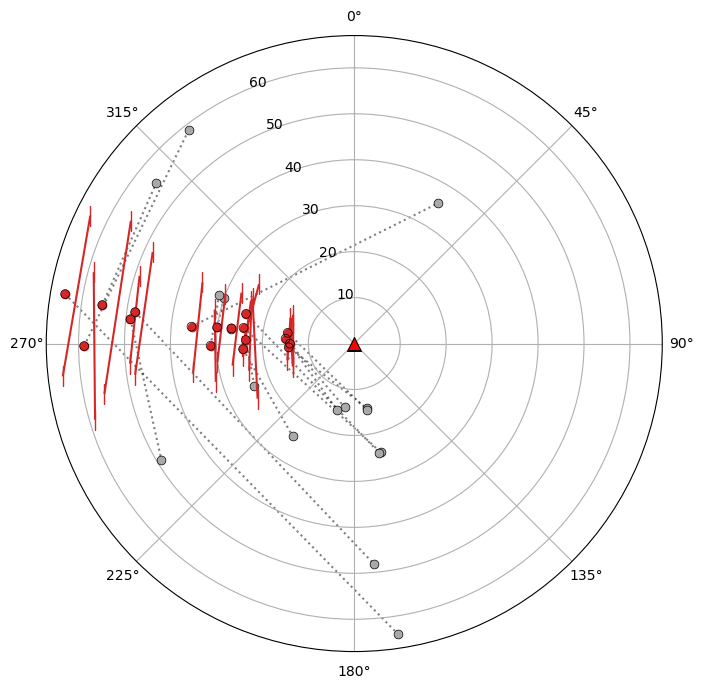

In [23]:
__polar_plot(df_baz)

In [24]:

config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']
config['eventtime'] = event_time

## specify window length for baz estimation in seconds
config['win_length_sec'] = 0.3

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

config['fmin'], config['fmax'] = 8, 15

config['cc_thres'] = 0.4

for fmin, fmax in ([(1,5), (4,8), (7,11), (8,12), (10,15)]):

    config['fmin'], config['fmax'] = fmin, fmax

    for rot_name in ["bspf","iadr"]:

            for i in range(0, 17):

                event_time = event_times.origin_time.loc[i]

                try:
                    event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
                    trig = triggered[triggered.origin == event_time]
                except:
                    print(f" -> {i} no event in catalog")


                ## prepare string
                event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

                st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");
                st = st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

                st = st.detrend("simple");
                st = st.taper(0.01);
                st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

                st = st.trim(st[0].stats.starttime+cut_offs[i][0]-10, st[0].stats.endtime-cut_offs[i][1]+10);

                acc = st.select(station="PFO*").copy();

                ## TAGENT

                if rot_name == "iadr":
                    rot = st.select(station="RPFO", location="in").copy(); #rot.select(channel="*Z")[0].data *= -1
                elif rot_name == "bspf":
                    rot = st.select(station="BSPF").copy();

                config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime

                out = __baz_tangent(rot, acc, win_time_s=config['win_length_sec'], overlap=config['overlap']/100,
                                    cc_thres=config['cc_thres'], baz_theo=trig.backazimuth.iloc[0], plot=False)
                # __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_tangent", mode="png", dpi=200)

                _baz = {}
                _baz['event_time'] = event_time
                _baz['event_num'] = num
                _baz['baz_mean'] = np.nanmean(out["baz_est"])
                _baz['baz_median'] = np.nanmedian(out["baz_est"])
                _baz['cc_thres'] = config['cc_thres']
                _baz['baz_theo'] = out["baz_theo"]
                _baz['baz_std'] = np.nanstd(out['baz_est'])
                _baz['percentile_05'] = np.nanpercentile(out['baz_est'], [5])
                _baz['percentile_90'] = np.nanpercentile(out['baz_est'], [90])
                _baz['samples'] = len(out['ccoef']) - np.isnan(out['ccoef']).sum()
                _baz['edist_km'] = trig.distances_km.iloc[0]

                if i == 0:
                    df_baz = pd.DataFrame([_baz])
                else:
                    df_baz.loc[len(df_baz)] = _baz

            df_baz.to_pickle(config['path_to_data']+"baz_test/"+f"bspf_baz_estimates_{rot_name}_{fmin}_{fmax}.pkl")
            print(f" -> writing: {config['path_to_data']}"+"baz_test/"+f"bspf_baz_estimates_{rot_name}_{fmin}_{fmax}.pkl")


 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_bspf_1_5.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_iadr_1_5.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_bspf_4_8.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_iadr_4_8.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_bspf_7_11.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_iadr_7_11.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_bspf_8_12.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_iadr_8_12.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_bspf_10_15.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/baz_test/bspf_baz_estimates_iadr_10_15.pkl


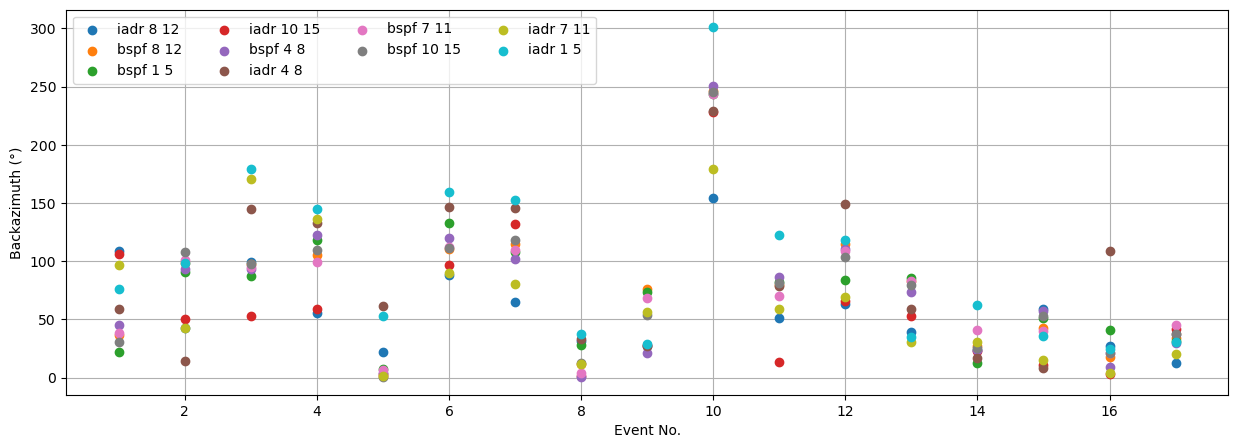

In [25]:
plt.figure(figsize=(15,5))

for n, file in enumerate(os.listdir(config['path_to_data']+"baz_test/")):
    dat = pd.read_pickle(config['path_to_data']+"baz_test/"+file)

    names = file.split(".")[0].split("_")

    data_baz = dat

    x = np.arange(1,len(data_baz.event_time)+1)

    # if n == 1:
    #     plt.scatter(x, data_baz.baz_theo, c="k", zorder=3, label="Baz. theo.")
    # plt.errorbar(x, data_baz.baz_mean, yerr=data_baz.baz_std, capsize=7, fmt="o", zorder=2, label="Baz. mean")

    plt.scatter(x, abs(data_baz.baz_theo-data_baz.baz_mean), zorder=3, label=f"{names[3]} {names[4]} {names[5]}")

plt.xlabel("Event No.")
plt.ylabel("Backazimuth (°)")
plt.legend(loc=2, ncol=4)
plt.grid(zorder=-1)
plt.show();